In [1]:
# Set up environment first.
# we will need current numpy for pygrib
import numpy as np, os
if not [int(i) for i in np.__version__.split('.')] >= [1,20,1]: # check numpy version
  print('Upgrading numpy and stopping RUNTIME! When the notebook completes, please run again.')
  ! pip install --upgrade numpy    # suggested by Efosa, see also https://github.com/jswhit/pygrib/issues/192
  os.kill(os.getpid(), 9)          # kill the runtime, need to run again from the beginning! pip install pygrib
! pip install pygrib   
! wget --no-clobber https://raw.githubusercontent.com/openwfm/wrfxpy/master/src/ingest/grib_file.py
from grib_file import GribFile     # Martin's utility layer on top of  pygrib,from wrfxpy

File ‘grib_file.py’ already there; not retrieving.



## Kalman filter

The Kalman filter provides an estimate $u$ of the time evolution of some unknown process, called "nature" or "truth". We do not know with certainty what the nature is, but we can observe it at regular intervals (steps) with some error. In each step, model $F$ advances the model state $u$ in time, $ u \leftarrow F(u)$, and attempts to reconcile the state with an observation $d$ of the true state, so $u \approx d$. The filter modifies the model state $u$ to balance the uncertainty in the model and the data (this is called *analysis*) and the cycle continues. For that purpose, the filter evolves also an estimate of the uncertainly of the model.

More generally, instead of $u \approx d$, only a part of the state is observed, and $Hu \approx d$ where $H$ is a matrix, or observation function. Basically, $Hu$ is what the data would be if the model was completely accurate. 

In [2]:
import numpy as np
def ext_kf(u,P,F,Q=0,d=None,H=None,R=None):
  """
  One step of the extended Kalman filter. 
  If there is no data, only advance in time.
  :param u:   the state vector, shape n
  :param P:   the state covariance, shape (n,n)
  :param Q:   the process model noise covariance, shape (n,n)
  :param F:   the model function, maps vector u to vector F(u) and Jacobian J(u)
  :param d:   data vector, shape (m)
  :param H:   observation matrix, shape (m,n)
  :param R:   data error covariance, shape (n,n)
  :return ua: the analysis state vector, shape (n)
  :return Pa: the analysis covariance matrix, shape (n,n)
  """
  def d2(a):
    return np.atleast_2d(a) # convert to at least 2d array

  def d1(a):
    return np.atleast_1d(a) # convert to at least 1d array

  # forecast
  uf, J  = F(u)          # advance the model state in time and get the Jacobian
  uf = d1(uf)            # if scalar, make state a 1D array
  P = d2(P)              # if scalar, make Jacobian as 2D array
  Pf  = d2(J.T @ P) @ J + Q  # advance the state covariance Pf = J' * P * J + Q
  # analysis
  if d is None or not d.size :  # no data, no analysis
    return uf, Pf
  # K = P H' * inverse(H * P * H' + R) = (inverse(H * P * H' + R)*(H P))'
  H = d2(H)
  HP  = d2(H @ P)            # precompute a part used twice  
  K   = d2(np.linalg.solve( d2(HP @ H.T) + R, HP)).T  # Kalman gain
  # print('H',H)
  # print('K',K)
  res = d1(H @ d1(uf) - d)          # res = H*uf - d
  ua = uf - K @ res # analysis mean uf - K*res
  Pa = Pf - K @ d2(H @ P)        # analysis covariance
  return ua, d2(Pa)


##  A basic exponential decay model of fuel moisture




The evolution of fuel moisture content $m(t)$ is modeled by the differential equation on interval $\left[
t_{0},t_{1}\right]  $,
$$
\frac{dm}{dt}=\frac{E-m(t)}{T},\quad m(t_{0})=m_{0}.
$$
where the initial fuel moisture content $m_{0}=m\left(  t_{0}\right)  $ is the
input, and $m_{1}=m(t_{1})$ is the output. Tnus, $m_1=F(m_0)$. The parameters of the model are the
fuel moisture equilibrium $E$, assumed to be constant over the interval $\left[
t_{0},t_{1}\right]  $, NS the characteristic decay time $T$. 

We can build the general model later by calling this simple model with different
equilibria and time constants (drying, wetting, rain).

Since $E$ is constant in time, the solution can be found
analytically,
$$
m\left(  t\right)  =E+\left(  m_{0}-E\right)  e^{-t/T}%
$$
For convenience, we use $T_{1}=1/T$ instead of $T$, and the model becomes
$$
m_{1}=E+\left(  m_{0}-E\right)  e^{-\left(  t_{1}-t_{0}\right)  T_{1}}%
$$
In the extended Kalman filter, we will need the partial derivatives of $m_{1}$
with respect to the input and the parameters. Compute
$$
\frac{dm_{1}}{d_{m0}}=e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dE}=1-e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dT_{1}}=-\left(  m_{0}-E\right)  \left(  t_{1}-t_{0}\right)
e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
At the moment, we need only ${dm_{1}}/{dm_{0}}$ but we put in the code all partials for possible use in future.


In [3]:
import numpy as np
def model_decay(m0,E,partials=0,T1=0.1,tlen=1):
  exp_t = np.exp(-tlen*T1)                  # compute this subexpression only once
  m1 = E + (m0 - E)*exp_t                   # the solution at end
  if partials==0:
    return m1
  dm1_dm0 = exp_t
  if partials==1:
    return m1, np.array([dm1_dm0])          # return value and Jacobian
  dm1_dE = 1 - exp_t                        # partial derivative dm1 / dE
  dm1_dT1 = -(m0 - E)*tlen*exp_t            # partial derivative dm1 / dT1
  return m1, dm1_dm0, dm1_dE, dm1_dT1       # return value and all partial derivatives wrt m1 and parameters
  

## Kalman filter demonstration

We demonstrate the Kalman filter for this model on a simple artificial example. The model is solving the differential equation for one hour. The equilibrium $E$ is constant during the hour, but it changes over the day so that it is higher at night and lower during the day, with a 24-hour period.  First, we create the "truth" by choosing the equilibrium $E$ and solving the differential aquation every hour, with a small additive noise. The synthetic data is obtained as values of the "truth", with random noise to simulate observation error.

### Create synthetic data

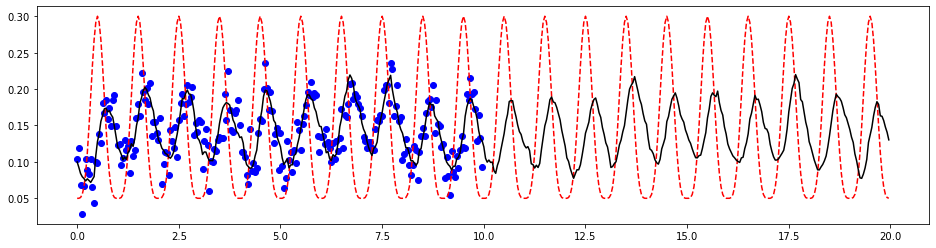

In [4]:
import numpy as np, random
days = 10       
hours = days*24
day = np.array(range(2*hours))/24.

# artificial equilibrium data
E = np.power(np.sin(np.pi*day),4) # diurnal curve
E = 0.05+0.25*E
E # scale 
# FMC free run
m_f = np.zeros(2*hours)
m_f[0] = 0.1         # initial FMC
for t in range(2*hours-1):
  m_f[t+1] = max(0.,model_decay(m_f[t],E[t])  + random.gauss(0,0.005) )
data = m_f + np.random.normal(loc=0,scale=0.02,size=2*hours)    

%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day[0:2*hours],E[0:2*hours],linestyle='--',c='r',label='Equilibrium')
plt.plot(day[0:2*hours],m_f[0:2*hours],linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
 

### Run Kalman filter

We have used the same code for model and for the truth, and run the Kalman filter for 10 days. The graph below shows that the model state was remarkably close to the truth, even if the model is fed only noisy observations. This is because the dynamics of the model and of the truth are the same. After 10 days, we let the model continue without any new data to simulate forecasting the future, and the agreement with the truth was still very good.

In [5]:
import numpy as np
import matplotlib.pyplot as plt 

def kf_example(DeltaE):
  m = np.zeros(2*hours)
  m[0]=0.1             # background state  
  P = np.zeros(2*hours)
  P[0] = 0.03 # background state variance
  Q = np.array([0.02]) # process noise variance
  H = np.array([1.])   # all observed
  R = np.array([0.02]) # data variance

  for t in range(hours):
    # use lambda construction to pass additional arguments to the model 
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
  for t in range(hours,2*hours - 1):
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
  %matplotlib inline
  plt.figure() # new figure
  plt.plot(day,P,linestyle='-',c='b',label='Estimated state variance P')
    
  %matplotlib inline
  plt.figure(figsize=(16,4))
  plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
  plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
  plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
  plt.plot(day,m,linestyle='-',c='r',label='filtered')

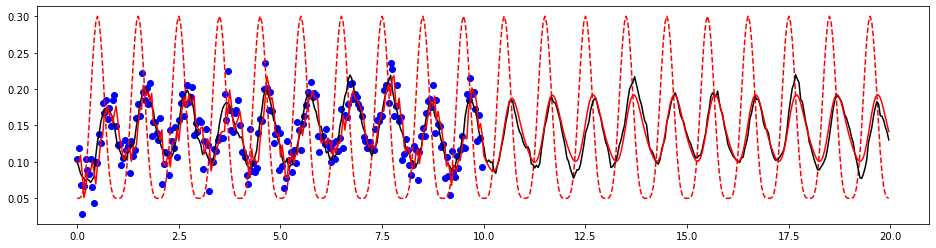

In [6]:
DeltaE = 0.0          # bias
kf_example(DeltaE)

We have recovered the fuel moisture from data with random noise - we **filtered** the noise out. 

Now what if the model is wrong - different from nature? That is always so in reality. Now suppose that the model and the truth are not the same. That is always the case in reality.  Consider a simple case when the model thinks that the equilibrium $E$ is too high.

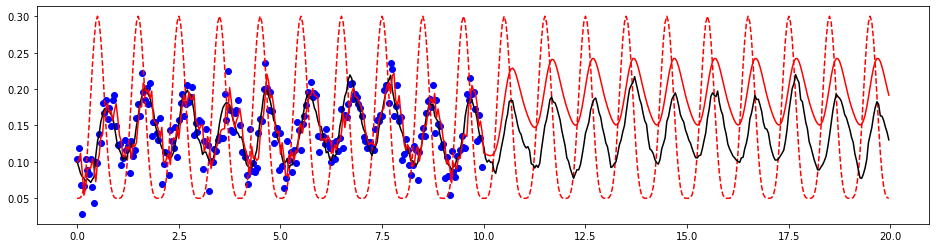

In [7]:
DeltaE = 0.05
kf_example(DeltaE)  

We have found a good estimate of the state $m$, while data is available. Also, the estimated state variance $P$ converges with time - we have *learned* the variance that balances the noise. But for forecasting fuel moisture, we need to continue the fuel moisture model into the future, and we can't have any measurements from future. We only have the equilibrium from weather forecast. And the forecast and the truth disagree.

## Real data

We retrieve the fuel moisture data from sensors on weather stations in the Mesowest network. 

In [8]:
!pip install MesoPy
from MesoPy import Meso

 Get all stations with fuel moisture data in a spatial box within one hour: 

In [9]:
# Take the first station in the boulding box that has data between time_start and time_s2.
# Then retrieve data for that station between time_start and time_end
time_start = "201806010800"  # June 1 2018 08:00 in format yyyymmddHHMM 
time_s2   = "201806010900"  # June 1 2018 09:00 in format yyyymmddHHMM 
time_end   = "201906200900"  # Nov 1 2018 09:00 in format yyyymmddHHMM 
bounding_box = "-115, 38, -110, 40"  # min longtitude, latitude
meso_token="b40cb52cbdef43ef81329b84e8fd874f"       # you should get your own if you do more of this
m = Meso(meso_token)                                     # create a Meso object
meso_obss = m.timeseries(time_start, time_s2, bbox=bounding_box, showemptystations = '0', vars='fuel_moisture')   # ask the object for data

In [10]:
meso_obss

{'UNITS': {'position': 'ft', 'fuel_moisture': 'gm', 'elevation': 'ft'},
 'QC_SUMMARY': {'QC_CHECKS_APPLIED': ['sl_range_check'],
  'TOTAL_OBSERVATIONS_FLAGGED': 0.0,
  'PERCENT_OF_TOTAL_OBSERVATIONS_FLAGGED': 0.0},
 'STATION': [{'STATUS': 'ACTIVE',
   'MNET_ID': '2',
   'PERIOD_OF_RECORD': {'start': '1997-01-01T00:00:00Z',
    'end': '2021-11-04T05:27:00Z'},
   'ELEVATION': '6493',
   'NAME': 'BLACK CEDAR',
   'STID': 'BKCU1',
   'SENSOR_VARIABLES': {'date_time': {'date_time': {}},
    'fuel_moisture': {'fuel_moisture_set_1': {'position': '0.98'}}},
   'ELEV_DEM': '6499.3',
   'LONGITUDE': '-112.238864',
   'STATE': 'UT',
   'OBSERVATIONS': {'date_time': ['2018-06-01T08:27:00Z'],
    'fuel_moisture_set_1': [4.9]},
   'RESTRICTED': False,
   'QC_FLAGGED': False,
   'LATITUDE': '38.979242',
   'TIMEZONE': 'America/Denver',
   'ID': '2328'},
  {'STATUS': 'ACTIVE',
   'MNET_ID': '2',
   'PERIOD_OF_RECORD': {'start': '1998-07-30T00:00:00Z',
    'end': '2021-11-04T05:12:00Z'},
   'ELEVATION'

Print the result:

In [11]:
import json
print(json.dumps(meso_obss, indent=4))


{
    "UNITS": {
        "position": "ft",
        "fuel_moisture": "gm",
        "elevation": "ft"
    },
    "QC_SUMMARY": {
        "QC_CHECKS_APPLIED": [
            "sl_range_check"
        ],
        "TOTAL_OBSERVATIONS_FLAGGED": 0.0,
        "PERCENT_OF_TOTAL_OBSERVATIONS_FLAGGED": 0.0
    },
    "STATION": [
        {
            "STATUS": "ACTIVE",
            "MNET_ID": "2",
            "PERIOD_OF_RECORD": {
                "start": "1997-01-01T00:00:00Z",
                "end": "2021-11-04T05:27:00Z"
            },
            "ELEVATION": "6493",
            "NAME": "BLACK CEDAR",
            "STID": "BKCU1",
            "SENSOR_VARIABLES": {
                "date_time": {
                    "date_time": {}
                },
                "fuel_moisture": {
                    "fuel_moisture_set_1": {
                        "position": "0.98"
                    }
                }
            },
            "ELEV_DEM": "6499.3",
            "LONGITUDE": "-112.238864",

Pick one station and get a time series for the station.

In [12]:
station=meso_obss['STATION'][0]
#print(json.dumps(station, indent=4))
lon,lat = (float(station['LONGITUDE']),float(station['LATITUDE']))
print(station['NAME'],'station',station['STID'],'at',lon,lat)
e = 0.01
bb = '%s, %s, %s, %s' % (lon - e, lat - e, lon + e, lat + e)
print('bounding box',bb)
meso_ts = m.timeseries(time_start, time_end, bbox=bb, showemptystations = '0', vars='fuel_moisture')   # ask the object for data
obs_lon, obs_lat = (lon, lat)   # remember station coordinates for later

BLACK CEDAR station BKCU1 at -112.238864 38.979242
bounding box -112.24886400000001, 38.969242, -112.228864, 38.989242


Text(0.5, 1.0, 'BKCU1 10 h fuel moisture data')

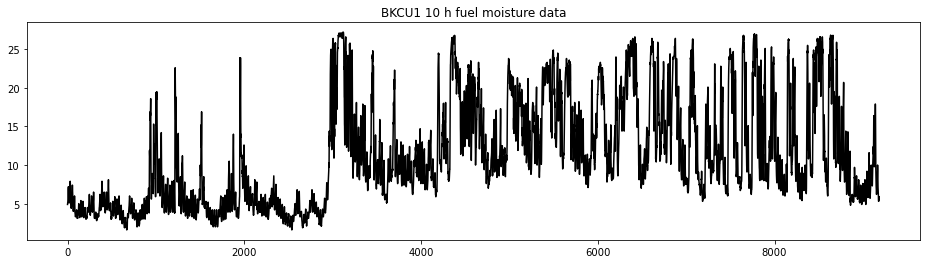

In [13]:
# process the data retrieved for this station
# print(json.dumps(meso_ts['STATION'][0], indent=4))
from datetime import datetime, timedelta, time
import pytz
time_str  = meso_ts['STATION'][0]['OBSERVATIONS']['date_time']
obs_time = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=pytz.UTC) for t in time_str]
start_time = obs_time[0].replace(minute=0)     # remember obs_time and start_time for later
end_time = obs_time[-1]
obs_data = np.array(meso_ts['STATION'][0]['OBSERVATIONS']["fuel_moisture_set_1"])
# display the data retrieved
#for o_time,o_data in zip (obs_time,obs_data):
#    print(o_time,o_data)
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(obs_data,linestyle='-',c='k',label='10-h fuel data')
plt.title(station['STID'] + ' 10 h fuel moisture data')


Next, we retrieve weather data for the duration of the station data, from our RTMA stash.

Create a function to transfer RTMA files in GRIB2 format from the stash. The function returns zero if the file transfer succeeded. If the file is not available, it returns a nonzero value. Note: if needed, maybe in future add more sophisticated checks, check the return code of wget and if the file size is correct.

In [14]:
import subprocess,os
def load_rtma(path,file,reload=0):
  url='http://math.ucdenver.edu/~jmandel/rtma/' + path 
  if os.path.exists(file):
    if reload:
      print(file + ' already exists, removing')
      os.remove(file)
    else:
      print(file + ' already exists, exiting')
      # add checking size here
      return 0
  try:
    ret = subprocess.check_output(['wget','--no-clobber','--output-document='+ file, url,],stderr=subprocess.STDOUT).decode() # execute command from python strings
    if os.path.exists(file):
      print('loaded ' + url + ' as ' + file)
      return 0
    else: 
      print('file transfer completed, but the file is missing? ' + url)  
      return 1
  except:
    print('file transfer failed: ' + url)
    return 2


Next, functions to get the files, open as grib, and interpolate to the station coordinates

In [15]:
def rtma_grib(t,var):
    tpath = '%4i%02i%02i/%02i' % (t.year, t.month, t.day, t.hour)
    tstr  = '%4i%02i%02i%02i_' % (t.year, t.month, t.day, t.hour)
    gribfile = tstr + var + '.grib'
    if load_rtma(tpath + '/' + var + '.grib',gribfile):
        print('cannot load file')
    gf=GribFile(gribfile)
    v = np.array(gf[1].values())
    print('loaded ',gribfile,' containing array shape ',v.shape)
    return gf[1]   # grib message


In [16]:
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
def interp_to_lat_lon_slow(lats,lons,v,lat,lon): 
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    interp=LinearNDInterpolator(list(zip(lats.flatten(),lons.flatten())),v.flatten())
    return interp(lat,lon)
def interp_to_lat_lon(lats,lons,v,lat,lon):
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    points=(np.array(range(lats.shape[0]),float),np.array(range(lats.shape[1]),float))  # uniform mesh
    def res(ij):  # interpolation of lons lats on the uniform mesh, to noninteger coordinates   
       return np.hstack((interpn(points,lats,ij)-lat, interpn(points,lons,ij)-lon))
    # solve for xi,xj such that lats(xi,xj)=lat lons(xi,xj)=lon, then interpolate to (xi, xj) on uniform grid 
    result = root(res,(0,0)) # solve res(ij) = 0
    if not result.success:
        print(result.message)
        exit(1)
    return interpn(points,v,result.x) 


The interpolation function needs to  be tested.

In [17]:
def interp_to_lat_lon_test(lats,lons):
    print('testing interp_to_lat_lon')
    vx, vy = np.meshgrid(range(lats.shape[0]),range(lats.shape[1]),indexing='ij')
    i, j = (1,2)
    lat,lon = ((lats[i,j]+lats[i+1,j+1])/2,(lons[i,j]+lons[i+1,j+1])/2)
    vi = interp_to_lat_lon(lats,lons,vx,lat,lon)
    vj = interp_to_lat_lon(lats,lons,vy,lat,lon)
    print(vi,vj,'should be about',i+0.5,j+0.5)
    test_slow = 0
    if test_slow:
        print('Testing against the standard slow method scipy.interpolate.LinearNDInterpolator. Please wait...')
        vi_slow = interp_to_lat_lon_slow(lats,lons,vx,lat,lon)
        print(vi_slow)
        vj_slow = interp_to_lat_lon_slow(lats,lons,vy,lat,lon)
        print(vj_slow)
gf = rtma_grib(start_time,'temp')      #  read the first grib file and use it to test interpolation
lats, lons = gf.latlons()
interp_to_lat_lon_test(lats,lons)


2018060108_temp.grib already exists, exiting
loaded  2018060108_temp.grib  containing array shape  (1377, 2145)
testing interp_to_lat_lon
[1.50000185] [2.50004253] should be about 1.5 2.5


Now we are ready to reading the RTMA files and interpolate to the station coordinates

In [20]:
import pandas as pd
def read_interp_rtma(varname):
    # read RTMA from start_time to end_time and interpolate to obs_lat obs_lon
    ret=[]
    for t in pd.date_range(start=start_time,end=end_time,freq='1H'):
        gf = rtma_grib(t,varname)   # read and create grib object, download if needed
        lats,lons = gf.latlons()    # coordinates
        v = gf.values()
        ret.append(interp_to_lat_lon(lats,lons,v,obs_lat,obs_lon)) # append to array
        print(varname,'at',t,'interpolated to',obs_lat,obs_lon)
    return np.array(ret)

temp =    read_interp_rtma('temp')      # temperature
td =      read_interp_rtma('td')        # dew point
precipa = read_interp_rtma('precipa')   # precipitation
print('Done. Strongly suggested save these arrays and obs_time obs_data to files and just start from that next time.')

2018060108_temp.grib already exists, exiting
loaded  2018060108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018060109_temp.grib already exists, exiting
loaded  2018060109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018060110_temp.grib already exists, exiting
loaded  2018060110_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018060111_temp.grib already exists, exiting
loaded  2018060111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018060112_temp.grib already exists, exiting
loaded  2018060112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018060113_temp.grib already exists, exiting
loaded  2018060113_temp.grib  conta

temp at 2018-06-03 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018060305_temp.grib already exists, exiting
loaded  2018060305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018060306_temp.grib already exists, exiting
loaded  2018060306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018060307_temp.grib already exists, exiting
loaded  2018060307_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018060308_temp.grib already exists, exiting
loaded  2018060308_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018060309_temp.grib already exists, exiting
loaded  2018060309_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 09:00:00+00:00 interpolated to 38.979242 -112.238864
20180603

temp at 2018-06-05 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018060502_temp.grib already exists, exiting
loaded  2018060502_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-05 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018060503_temp.grib already exists, exiting
loaded  2018060503_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-05 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018060504_temp.grib already exists, exiting
loaded  2018060504_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-05 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018060505_temp.grib already exists, exiting
loaded  2018060505_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-05 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018060506_temp.grib already exists, exiting
loaded  2018060506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-05 06:00:00+00:00 interpolated to 38.979242 -112.238864
20180605

temp at 2018-06-06 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018060623_temp.grib already exists, exiting
loaded  2018060623_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-06 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018060700_temp.grib already exists, exiting
loaded  2018060700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-07 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018060701_temp.grib already exists, exiting
loaded  2018060701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-07 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018060702_temp.grib already exists, exiting
loaded  2018060702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-07 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018060703_temp.grib already exists, exiting
loaded  2018060703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-07 03:00:00+00:00 interpolated to 38.979242 -112.238864
20180607

temp at 2018-06-08 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018060820_temp.grib already exists, exiting
loaded  2018060820_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-08 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018060821_temp.grib already exists, exiting
loaded  2018060821_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-08 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018060822_temp.grib already exists, exiting
loaded  2018060822_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-08 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018060823_temp.grib already exists, exiting
loaded  2018060823_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-08 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018060900_temp.grib already exists, exiting
loaded  2018060900_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-09 00:00:00+00:00 interpolated to 38.979242 -112.238864
20180609

temp at 2018-06-10 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018061017_temp.grib already exists, exiting
loaded  2018061017_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-10 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018061018_temp.grib already exists, exiting
loaded  2018061018_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-10 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018061019_temp.grib already exists, exiting
loaded  2018061019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-10 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018061020_temp.grib already exists, exiting
loaded  2018061020_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-10 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018061021_temp.grib already exists, exiting
loaded  2018061021_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-10 21:00:00+00:00 interpolated to 38.979242 -112.238864
20180610

temp at 2018-06-12 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018061214_temp.grib already exists, exiting
loaded  2018061214_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018061215_temp.grib already exists, exiting
loaded  2018061215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018061216_temp.grib already exists, exiting
loaded  2018061216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018061217_temp.grib already exists, exiting
loaded  2018061217_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018061218_temp.grib already exists, exiting
loaded  2018061218_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 18:00:00+00:00 interpolated to 38.979242 -112.238864
20180612

temp at 2018-06-14 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018061411_temp.grib already exists, exiting
loaded  2018061411_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018061412_temp.grib already exists, exiting
loaded  2018061412_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018061413_temp.grib already exists, exiting
loaded  2018061413_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018061414_temp.grib already exists, exiting
loaded  2018061414_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018061415_temp.grib already exists, exiting
loaded  2018061415_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 15:00:00+00:00 interpolated to 38.979242 -112.238864
20180614

temp at 2018-06-16 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018061608_temp.grib already exists, exiting
loaded  2018061608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018061609_temp.grib already exists, exiting
loaded  2018061609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018061610_temp.grib already exists, exiting
loaded  2018061610_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018061611_temp.grib already exists, exiting
loaded  2018061611_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018061612_temp.grib already exists, exiting
loaded  2018061612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 12:00:00+00:00 interpolated to 38.979242 -112.238864
20180616

temp at 2018-06-18 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018061805_temp.grib already exists, exiting
loaded  2018061805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-18 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018061806_temp.grib already exists, exiting
loaded  2018061806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-18 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018061807_temp.grib already exists, exiting
loaded  2018061807_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-18 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018061808_temp.grib already exists, exiting
loaded  2018061808_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-18 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018061809_temp.grib already exists, exiting
loaded  2018061809_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-18 09:00:00+00:00 interpolated to 38.979242 -112.238864
20180618

temp at 2018-06-20 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018062002_temp.grib already exists, exiting
loaded  2018062002_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018062003_temp.grib already exists, exiting
loaded  2018062003_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018062004_temp.grib already exists, exiting
loaded  2018062004_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018062005_temp.grib already exists, exiting
loaded  2018062005_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018062006_temp.grib already exists, exiting
loaded  2018062006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 06:00:00+00:00 interpolated to 38.979242 -112.238864
20180620

temp at 2018-06-21 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018062123_temp.grib already exists, exiting
loaded  2018062123_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-21 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018062200_temp.grib already exists, exiting
loaded  2018062200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018062201_temp.grib already exists, exiting
loaded  2018062201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018062202_temp.grib already exists, exiting
loaded  2018062202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018062203_temp.grib already exists, exiting
loaded  2018062203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 03:00:00+00:00 interpolated to 38.979242 -112.238864
20180622

temp at 2018-06-23 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018062320_temp.grib already exists, exiting
loaded  2018062320_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-23 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018062321_temp.grib already exists, exiting
loaded  2018062321_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-23 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018062322_temp.grib already exists, exiting
loaded  2018062322_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-23 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018062323_temp.grib already exists, exiting
loaded  2018062323_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-23 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018062400_temp.grib already exists, exiting
loaded  2018062400_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-24 00:00:00+00:00 interpolated to 38.979242 -112.238864
20180624

temp at 2018-06-25 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018062517_temp.grib already exists, exiting
loaded  2018062517_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018062518_temp.grib already exists, exiting
loaded  2018062518_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018062519_temp.grib already exists, exiting
loaded  2018062519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018062520_temp.grib already exists, exiting
loaded  2018062520_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018062521_temp.grib already exists, exiting
loaded  2018062521_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 21:00:00+00:00 interpolated to 38.979242 -112.238864
20180625

temp at 2018-06-27 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018062714_temp.grib already exists, exiting
loaded  2018062714_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018062715_temp.grib already exists, exiting
loaded  2018062715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018062716_temp.grib already exists, exiting
loaded  2018062716_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018062717_temp.grib already exists, exiting
loaded  2018062717_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018062718_temp.grib already exists, exiting
loaded  2018062718_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 18:00:00+00:00 interpolated to 38.979242 -112.238864
20180627

temp at 2018-06-29 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018062911_temp.grib already exists, exiting
loaded  2018062911_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018062912_temp.grib already exists, exiting
loaded  2018062912_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018062913_temp.grib already exists, exiting
loaded  2018062913_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018062914_temp.grib already exists, exiting
loaded  2018062914_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018062915_temp.grib already exists, exiting
loaded  2018062915_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 15:00:00+00:00 interpolated to 38.979242 -112.238864
20180629

temp at 2018-07-01 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018070108_temp.grib already exists, exiting
loaded  2018070108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-01 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018070109_temp.grib already exists, exiting
loaded  2018070109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-01 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018070110_temp.grib already exists, exiting
loaded  2018070110_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-01 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018070111_temp.grib already exists, exiting
loaded  2018070111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-01 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018070112_temp.grib already exists, exiting
loaded  2018070112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-01 12:00:00+00:00 interpolated to 38.979242 -112.238864
20180701

temp at 2018-07-03 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018070305_temp.grib already exists, exiting
loaded  2018070305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018070306_temp.grib already exists, exiting
loaded  2018070306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018070307_temp.grib already exists, exiting
loaded  2018070307_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018070308_temp.grib already exists, exiting
loaded  2018070308_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018070309_temp.grib already exists, exiting
loaded  2018070309_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 09:00:00+00:00 interpolated to 38.979242 -112.238864
20180703

temp at 2018-07-05 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018070502_temp.grib already exists, exiting
loaded  2018070502_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018070503_temp.grib already exists, exiting
loaded  2018070503_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018070504_temp.grib already exists, exiting
loaded  2018070504_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018070505_temp.grib already exists, exiting
loaded  2018070505_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018070506_temp.grib already exists, exiting
loaded  2018070506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 06:00:00+00:00 interpolated to 38.979242 -112.238864
20180705

temp at 2018-07-06 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018070623_temp.grib already exists, exiting
loaded  2018070623_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-06 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018070700_temp.grib already exists, exiting
loaded  2018070700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018070701_temp.grib already exists, exiting
loaded  2018070701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018070702_temp.grib already exists, exiting
loaded  2018070702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018070703_temp.grib already exists, exiting
loaded  2018070703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 03:00:00+00:00 interpolated to 38.979242 -112.238864
20180707

temp at 2018-07-08 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018070820_temp.grib already exists, exiting
loaded  2018070820_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018070821_temp.grib already exists, exiting
loaded  2018070821_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018070822_temp.grib already exists, exiting
loaded  2018070822_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018070823_temp.grib already exists, exiting
loaded  2018070823_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018070900_temp.grib already exists, exiting
loaded  2018070900_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-09 00:00:00+00:00 interpolated to 38.979242 -112.238864
20180709

temp at 2018-07-10 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018071017_temp.grib already exists, exiting
loaded  2018071017_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018071018_temp.grib already exists, exiting
loaded  2018071018_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018071019_temp.grib already exists, exiting
loaded  2018071019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018071020_temp.grib already exists, exiting
loaded  2018071020_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018071021_temp.grib already exists, exiting
loaded  2018071021_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 21:00:00+00:00 interpolated to 38.979242 -112.238864
20180710

temp at 2018-07-12 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018071214_temp.grib already exists, exiting
loaded  2018071214_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018071215_temp.grib already exists, exiting
loaded  2018071215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018071216_temp.grib already exists, exiting
loaded  2018071216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018071217_temp.grib already exists, exiting
loaded  2018071217_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018071218_temp.grib already exists, exiting
loaded  2018071218_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 18:00:00+00:00 interpolated to 38.979242 -112.238864
20180712

temp at 2018-07-14 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018071411_temp.grib already exists, exiting
loaded  2018071411_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-14 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018071412_temp.grib already exists, exiting
loaded  2018071412_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-14 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018071413_temp.grib already exists, exiting
loaded  2018071413_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-14 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018071414_temp.grib already exists, exiting
loaded  2018071414_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-14 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018071415_temp.grib already exists, exiting
loaded  2018071415_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-14 15:00:00+00:00 interpolated to 38.979242 -112.238864
20180714

temp at 2018-07-16 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018071608_temp.grib already exists, exiting
loaded  2018071608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018071609_temp.grib already exists, exiting
loaded  2018071609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018071610_temp.grib already exists, exiting
loaded  2018071610_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018071611_temp.grib already exists, exiting
loaded  2018071611_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018071612_temp.grib already exists, exiting
loaded  2018071612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 12:00:00+00:00 interpolated to 38.979242 -112.238864
20180716

temp at 2018-07-18 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018071805_temp.grib already exists, exiting
loaded  2018071805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018071806_temp.grib already exists, exiting
loaded  2018071806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018071807_temp.grib already exists, exiting
loaded  2018071807_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018071808_temp.grib already exists, exiting
loaded  2018071808_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018071809_temp.grib already exists, exiting
loaded  2018071809_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 09:00:00+00:00 interpolated to 38.979242 -112.238864
20180718

temp at 2018-07-20 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018072002_temp.grib already exists, exiting
loaded  2018072002_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018072003_temp.grib already exists, exiting
loaded  2018072003_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018072004_temp.grib already exists, exiting
loaded  2018072004_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018072005_temp.grib already exists, exiting
loaded  2018072005_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018072006_temp.grib already exists, exiting
loaded  2018072006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 06:00:00+00:00 interpolated to 38.979242 -112.238864
20180720

temp at 2018-07-21 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018072123_temp.grib already exists, exiting
loaded  2018072123_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-21 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018072200_temp.grib already exists, exiting
loaded  2018072200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-22 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018072201_temp.grib already exists, exiting
loaded  2018072201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-22 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018072202_temp.grib already exists, exiting
loaded  2018072202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-22 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018072203_temp.grib already exists, exiting
loaded  2018072203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-22 03:00:00+00:00 interpolated to 38.979242 -112.238864
20180722

temp at 2018-07-23 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018072320_temp.grib already exists, exiting
loaded  2018072320_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018072321_temp.grib already exists, exiting
loaded  2018072321_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018072322_temp.grib already exists, exiting
loaded  2018072322_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018072323_temp.grib already exists, exiting
loaded  2018072323_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018072400_temp.grib already exists, exiting
loaded  2018072400_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-24 00:00:00+00:00 interpolated to 38.979242 -112.238864
20180724

temp at 2018-07-25 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018072517_temp.grib already exists, exiting
loaded  2018072517_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018072518_temp.grib already exists, exiting
loaded  2018072518_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018072519_temp.grib already exists, exiting
loaded  2018072519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018072520_temp.grib already exists, exiting
loaded  2018072520_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018072521_temp.grib already exists, exiting
loaded  2018072521_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 21:00:00+00:00 interpolated to 38.979242 -112.238864
20180725

temp at 2018-07-27 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018072714_temp.grib already exists, exiting
loaded  2018072714_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-27 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018072715_temp.grib already exists, exiting
loaded  2018072715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-27 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018072716_temp.grib already exists, exiting
loaded  2018072716_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-27 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018072717_temp.grib already exists, exiting
loaded  2018072717_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-27 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018072718_temp.grib already exists, exiting
loaded  2018072718_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-27 18:00:00+00:00 interpolated to 38.979242 -112.238864
20180727

temp at 2018-07-29 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018072911_temp.grib already exists, exiting
loaded  2018072911_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018072912_temp.grib already exists, exiting
loaded  2018072912_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018072913_temp.grib already exists, exiting
loaded  2018072913_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018072914_temp.grib already exists, exiting
loaded  2018072914_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018072915_temp.grib already exists, exiting
loaded  2018072915_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 15:00:00+00:00 interpolated to 38.979242 -112.238864
20180729

temp at 2018-07-31 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018073108_temp.grib already exists, exiting
loaded  2018073108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018073109_temp.grib already exists, exiting
loaded  2018073109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018073110_temp.grib already exists, exiting
loaded  2018073110_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018073111_temp.grib already exists, exiting
loaded  2018073111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018073112_temp.grib already exists, exiting
loaded  2018073112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 12:00:00+00:00 interpolated to 38.979242 -112.238864
20180731

temp at 2018-08-02 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018080205_temp.grib already exists, exiting
loaded  2018080205_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018080206_temp.grib already exists, exiting
loaded  2018080206_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018080207_temp.grib already exists, exiting
loaded  2018080207_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018080208_temp.grib already exists, exiting
loaded  2018080208_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018080209_temp.grib already exists, exiting
loaded  2018080209_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 09:00:00+00:00 interpolated to 38.979242 -112.238864
20180802

temp at 2018-08-04 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018080402_temp.grib already exists, exiting
loaded  2018080402_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-04 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018080403_temp.grib already exists, exiting
loaded  2018080403_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-04 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018080404_temp.grib already exists, exiting
loaded  2018080404_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-04 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018080405_temp.grib already exists, exiting
loaded  2018080405_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-04 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018080406_temp.grib already exists, exiting
loaded  2018080406_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-04 06:00:00+00:00 interpolated to 38.979242 -112.238864
20180804

temp at 2018-08-05 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018080523_temp.grib already exists, exiting
loaded  2018080523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-05 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018080600_temp.grib already exists, exiting
loaded  2018080600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-06 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018080601_temp.grib already exists, exiting
loaded  2018080601_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-06 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018080602_temp.grib already exists, exiting
loaded  2018080602_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-06 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018080603_temp.grib already exists, exiting
loaded  2018080603_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-06 03:00:00+00:00 interpolated to 38.979242 -112.238864
20180806

temp at 2018-08-07 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018080720_temp.grib already exists, exiting
loaded  2018080720_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018080721_temp.grib already exists, exiting
loaded  2018080721_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018080722_temp.grib already exists, exiting
loaded  2018080722_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018080723_temp.grib already exists, exiting
loaded  2018080723_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018080800_temp.grib already exists, exiting
loaded  2018080800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-08 00:00:00+00:00 interpolated to 38.979242 -112.238864
20180808

temp at 2018-08-09 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018080917_temp.grib already exists, exiting
loaded  2018080917_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-09 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018080918_temp.grib already exists, exiting
loaded  2018080918_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-09 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018080919_temp.grib already exists, exiting
loaded  2018080919_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-09 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018080920_temp.grib already exists, exiting
loaded  2018080920_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-09 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018080921_temp.grib already exists, exiting
loaded  2018080921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-09 21:00:00+00:00 interpolated to 38.979242 -112.238864
20180809

temp at 2018-08-11 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018081114_temp.grib already exists, exiting
loaded  2018081114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018081115_temp.grib already exists, exiting
loaded  2018081115_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018081116_temp.grib already exists, exiting
loaded  2018081116_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018081117_temp.grib already exists, exiting
loaded  2018081117_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018081118_temp.grib already exists, exiting
loaded  2018081118_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 18:00:00+00:00 interpolated to 38.979242 -112.238864
20180811

temp at 2018-08-13 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018081311_temp.grib already exists, exiting
loaded  2018081311_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018081312_temp.grib already exists, exiting
loaded  2018081312_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018081313_temp.grib already exists, exiting
loaded  2018081313_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018081314_temp.grib already exists, exiting
loaded  2018081314_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018081315_temp.grib already exists, exiting
loaded  2018081315_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 15:00:00+00:00 interpolated to 38.979242 -112.238864
20180813

temp at 2018-08-15 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018081508_temp.grib already exists, exiting
loaded  2018081508_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018081509_temp.grib already exists, exiting
loaded  2018081509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018081510_temp.grib already exists, exiting
loaded  2018081510_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018081511_temp.grib already exists, exiting
loaded  2018081511_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018081512_temp.grib already exists, exiting
loaded  2018081512_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 12:00:00+00:00 interpolated to 38.979242 -112.238864
20180815

temp at 2018-08-17 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018081705_temp.grib already exists, exiting
loaded  2018081705_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-17 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018081706_temp.grib already exists, exiting
loaded  2018081706_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-17 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018081707_temp.grib already exists, exiting
loaded  2018081707_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-17 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018081708_temp.grib already exists, exiting
loaded  2018081708_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-17 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018081709_temp.grib already exists, exiting
loaded  2018081709_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-17 09:00:00+00:00 interpolated to 38.979242 -112.238864
20180817

temp at 2018-08-19 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018081902_temp.grib already exists, exiting
loaded  2018081902_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-19 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018081903_temp.grib already exists, exiting
loaded  2018081903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-19 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018081904_temp.grib already exists, exiting
loaded  2018081904_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-19 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018081905_temp.grib already exists, exiting
loaded  2018081905_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-19 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018081906_temp.grib already exists, exiting
loaded  2018081906_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-19 06:00:00+00:00 interpolated to 38.979242 -112.238864
20180819

temp at 2018-08-20 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018082023_temp.grib already exists, exiting
loaded  2018082023_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-20 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018082100_temp.grib already exists, exiting
loaded  2018082100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018082101_temp.grib already exists, exiting
loaded  2018082101_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018082102_temp.grib already exists, exiting
loaded  2018082102_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018082103_temp.grib already exists, exiting
loaded  2018082103_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 03:00:00+00:00 interpolated to 38.979242 -112.238864
20180821

temp at 2018-08-22 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018082220_temp.grib already exists, exiting
loaded  2018082220_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-22 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018082221_temp.grib already exists, exiting
loaded  2018082221_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-22 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018082222_temp.grib already exists, exiting
loaded  2018082222_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-22 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018082223_temp.grib already exists, exiting
loaded  2018082223_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-22 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018082300_temp.grib already exists, exiting
loaded  2018082300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-23 00:00:00+00:00 interpolated to 38.979242 -112.238864
20180823

temp at 2018-08-24 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018082417_temp.grib already exists, exiting
loaded  2018082417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018082418_temp.grib already exists, exiting
loaded  2018082418_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018082419_temp.grib already exists, exiting
loaded  2018082419_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018082420_temp.grib already exists, exiting
loaded  2018082420_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018082421_temp.grib already exists, exiting
loaded  2018082421_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 21:00:00+00:00 interpolated to 38.979242 -112.238864
20180824

temp at 2018-08-26 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018082614_temp.grib already exists, exiting
loaded  2018082614_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018082615_temp.grib already exists, exiting
loaded  2018082615_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018082616_temp.grib already exists, exiting
loaded  2018082616_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018082617_temp.grib already exists, exiting
loaded  2018082617_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018082618_temp.grib already exists, exiting
loaded  2018082618_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 18:00:00+00:00 interpolated to 38.979242 -112.238864
20180826

temp at 2018-08-28 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018082811_temp.grib already exists, exiting
loaded  2018082811_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018082812_temp.grib already exists, exiting
loaded  2018082812_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018082813_temp.grib already exists, exiting
loaded  2018082813_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018082814_temp.grib already exists, exiting
loaded  2018082814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018082815_temp.grib already exists, exiting
loaded  2018082815_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 15:00:00+00:00 interpolated to 38.979242 -112.238864
20180828

temp at 2018-08-30 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018083008_temp.grib already exists, exiting
loaded  2018083008_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-30 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018083009_temp.grib already exists, exiting
loaded  2018083009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-30 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018083010_temp.grib already exists, exiting
loaded  2018083010_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-30 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018083011_temp.grib already exists, exiting
loaded  2018083011_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-30 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018083012_temp.grib already exists, exiting
loaded  2018083012_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-30 12:00:00+00:00 interpolated to 38.979242 -112.238864
20180830

temp at 2018-09-01 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018090105_temp.grib already exists, exiting
loaded  2018090105_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-01 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018090106_temp.grib already exists, exiting
loaded  2018090106_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-01 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018090107_temp.grib already exists, exiting
loaded  2018090107_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-01 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018090108_temp.grib already exists, exiting
loaded  2018090108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-01 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018090109_temp.grib already exists, exiting
loaded  2018090109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-01 09:00:00+00:00 interpolated to 38.979242 -112.238864
20180901

temp at 2018-09-03 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018090302_temp.grib already exists, exiting
loaded  2018090302_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018090303_temp.grib already exists, exiting
loaded  2018090303_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018090304_temp.grib already exists, exiting
loaded  2018090304_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018090305_temp.grib already exists, exiting
loaded  2018090305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018090306_temp.grib already exists, exiting
loaded  2018090306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 06:00:00+00:00 interpolated to 38.979242 -112.238864
20180903

temp at 2018-09-04 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018090423_temp.grib already exists, exiting
loaded  2018090423_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-04 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018090500_temp.grib already exists, exiting
loaded  2018090500_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018090501_temp.grib already exists, exiting
loaded  2018090501_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018090502_temp.grib already exists, exiting
loaded  2018090502_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018090503_temp.grib already exists, exiting
loaded  2018090503_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 03:00:00+00:00 interpolated to 38.979242 -112.238864
20180905

temp at 2018-09-06 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018090620_temp.grib already exists, exiting
loaded  2018090620_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018090621_temp.grib already exists, exiting
loaded  2018090621_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018090622_temp.grib already exists, exiting
loaded  2018090622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018090623_temp.grib already exists, exiting
loaded  2018090623_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018090700_temp.grib already exists, exiting
loaded  2018090700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-07 00:00:00+00:00 interpolated to 38.979242 -112.238864
20180907

temp at 2018-09-08 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018090817_temp.grib already exists, exiting
loaded  2018090817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018090818_temp.grib already exists, exiting
loaded  2018090818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018090819_temp.grib already exists, exiting
loaded  2018090819_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018090820_temp.grib already exists, exiting
loaded  2018090820_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018090821_temp.grib already exists, exiting
loaded  2018090821_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 21:00:00+00:00 interpolated to 38.979242 -112.238864
20180908

temp at 2018-09-10 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018091014_temp.grib already exists, exiting
loaded  2018091014_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018091015_temp.grib already exists, exiting
loaded  2018091015_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018091016_temp.grib already exists, exiting
loaded  2018091016_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018091017_temp.grib already exists, exiting
loaded  2018091017_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018091018_temp.grib already exists, exiting
loaded  2018091018_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 18:00:00+00:00 interpolated to 38.979242 -112.238864
20180910

temp at 2018-09-12 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018091211_temp.grib already exists, exiting
loaded  2018091211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-12 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018091212_temp.grib already exists, exiting
loaded  2018091212_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-12 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018091213_temp.grib already exists, exiting
loaded  2018091213_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-12 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018091214_temp.grib already exists, exiting
loaded  2018091214_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-12 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018091215_temp.grib already exists, exiting
loaded  2018091215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-12 15:00:00+00:00 interpolated to 38.979242 -112.238864
20180912

temp at 2018-09-14 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018091408_temp.grib already exists, exiting
loaded  2018091408_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-14 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018091409_temp.grib already exists, exiting
loaded  2018091409_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-14 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018091410_temp.grib already exists, exiting
loaded  2018091410_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-14 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018091411_temp.grib already exists, exiting
loaded  2018091411_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-14 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018091412_temp.grib already exists, exiting
loaded  2018091412_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-14 12:00:00+00:00 interpolated to 38.979242 -112.238864
20180914

temp at 2018-09-16 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018091605_temp.grib already exists, exiting
loaded  2018091605_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018091606_temp.grib already exists, exiting
loaded  2018091606_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018091607_temp.grib already exists, exiting
loaded  2018091607_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018091608_temp.grib already exists, exiting
loaded  2018091608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018091609_temp.grib already exists, exiting
loaded  2018091609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 09:00:00+00:00 interpolated to 38.979242 -112.238864
20180916

temp at 2018-09-18 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018091802_temp.grib already exists, exiting
loaded  2018091802_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018091803_temp.grib already exists, exiting
loaded  2018091803_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018091804_temp.grib already exists, exiting
loaded  2018091804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018091805_temp.grib already exists, exiting
loaded  2018091805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018091806_temp.grib already exists, exiting
loaded  2018091806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 06:00:00+00:00 interpolated to 38.979242 -112.238864
20180918

temp at 2018-09-19 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018091923_temp.grib already exists, exiting
loaded  2018091923_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-19 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018092000_temp.grib already exists, exiting
loaded  2018092000_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-20 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018092001_temp.grib already exists, exiting
loaded  2018092001_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-20 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018092002_temp.grib already exists, exiting
loaded  2018092002_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-20 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018092003_temp.grib already exists, exiting
loaded  2018092003_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-20 03:00:00+00:00 interpolated to 38.979242 -112.238864
20180920

temp at 2018-09-21 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018092120_temp.grib already exists, exiting
loaded  2018092120_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018092121_temp.grib already exists, exiting
loaded  2018092121_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018092122_temp.grib already exists, exiting
loaded  2018092122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018092123_temp.grib already exists, exiting
loaded  2018092123_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018092200_temp.grib already exists, exiting
loaded  2018092200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-22 00:00:00+00:00 interpolated to 38.979242 -112.238864
20180922

temp at 2018-09-23 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018092317_temp.grib already exists, exiting
loaded  2018092317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018092318_temp.grib already exists, exiting
loaded  2018092318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018092319_temp.grib already exists, exiting
loaded  2018092319_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018092320_temp.grib already exists, exiting
loaded  2018092320_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018092321_temp.grib already exists, exiting
loaded  2018092321_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 21:00:00+00:00 interpolated to 38.979242 -112.238864
20180923

temp at 2018-09-25 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018092514_temp.grib already exists, exiting
loaded  2018092514_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-25 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018092515_temp.grib already exists, exiting
loaded  2018092515_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-25 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018092516_temp.grib already exists, exiting
loaded  2018092516_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-25 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018092517_temp.grib already exists, exiting
loaded  2018092517_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-25 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018092518_temp.grib already exists, exiting
loaded  2018092518_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-25 18:00:00+00:00 interpolated to 38.979242 -112.238864
20180925

temp at 2018-09-27 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018092711_temp.grib already exists, exiting
loaded  2018092711_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-27 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018092712_temp.grib already exists, exiting
loaded  2018092712_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-27 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018092713_temp.grib already exists, exiting
loaded  2018092713_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-27 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018092714_temp.grib already exists, exiting
loaded  2018092714_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-27 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018092715_temp.grib already exists, exiting
loaded  2018092715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-27 15:00:00+00:00 interpolated to 38.979242 -112.238864
20180927

temp at 2018-09-29 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018092908_temp.grib already exists, exiting
loaded  2018092908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018092909_temp.grib already exists, exiting
loaded  2018092909_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018092910_temp.grib already exists, exiting
loaded  2018092910_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018092911_temp.grib already exists, exiting
loaded  2018092911_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018092912_temp.grib already exists, exiting
loaded  2018092912_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 12:00:00+00:00 interpolated to 38.979242 -112.238864
20180929

temp at 2018-10-01 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018100105_temp.grib already exists, exiting
loaded  2018100105_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018100106_temp.grib already exists, exiting
loaded  2018100106_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018100107_temp.grib already exists, exiting
loaded  2018100107_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018100108_temp.grib already exists, exiting
loaded  2018100108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018100109_temp.grib already exists, exiting
loaded  2018100109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 09:00:00+00:00 interpolated to 38.979242 -112.238864
20181001

temp at 2018-10-03 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018100302_temp.grib already exists, exiting
loaded  2018100302_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018100303_temp.grib already exists, exiting
loaded  2018100303_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018100304_temp.grib already exists, exiting
loaded  2018100304_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018100305_temp.grib already exists, exiting
loaded  2018100305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018100306_temp.grib already exists, exiting
loaded  2018100306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 06:00:00+00:00 interpolated to 38.979242 -112.238864
20181003

temp at 2018-10-04 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018100423_temp.grib already exists, exiting
loaded  2018100423_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-04 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018100500_temp.grib already exists, exiting
loaded  2018100500_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-05 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018100501_temp.grib already exists, exiting
loaded  2018100501_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-05 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018100502_temp.grib already exists, exiting
loaded  2018100502_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-05 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018100503_temp.grib already exists, exiting
loaded  2018100503_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-05 03:00:00+00:00 interpolated to 38.979242 -112.238864
20181005

temp at 2018-10-06 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018100620_temp.grib already exists, exiting
loaded  2018100620_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018100621_temp.grib already exists, exiting
loaded  2018100621_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018100622_temp.grib already exists, exiting
loaded  2018100622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018100623_temp.grib already exists, exiting
loaded  2018100623_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018100700_temp.grib already exists, exiting
loaded  2018100700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-07 00:00:00+00:00 interpolated to 38.979242 -112.238864
20181007

temp at 2018-10-08 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018100817_temp.grib already exists, exiting
loaded  2018100817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-08 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018100818_temp.grib already exists, exiting
loaded  2018100818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-08 18:00:00+00:00 interpolated to 38.979242 -112.238864
2018100819_temp.grib already exists, exiting
loaded  2018100819_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-08 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018100820_temp.grib already exists, exiting
loaded  2018100820_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-08 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018100821_temp.grib already exists, exiting
loaded  2018100821_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-08 21:00:00+00:00 interpolated to 38.979242 -112.238864
20181008

temp at 2018-10-10 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018101014_temp.grib already exists, exiting
loaded  2018101014_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-10 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018101015_temp.grib already exists, exiting
loaded  2018101015_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-10 15:00:00+00:00 interpolated to 38.979242 -112.238864
2018101016_temp.grib already exists, exiting
loaded  2018101016_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-10 16:00:00+00:00 interpolated to 38.979242 -112.238864
2018101017_temp.grib already exists, exiting
loaded  2018101017_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-10 17:00:00+00:00 interpolated to 38.979242 -112.238864
2018101018_temp.grib already exists, exiting
loaded  2018101018_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-10 18:00:00+00:00 interpolated to 38.979242 -112.238864
20181010

temp at 2018-10-12 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018101211_temp.grib already exists, exiting
loaded  2018101211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018101212_temp.grib already exists, exiting
loaded  2018101212_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 12:00:00+00:00 interpolated to 38.979242 -112.238864
2018101213_temp.grib already exists, exiting
loaded  2018101213_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 13:00:00+00:00 interpolated to 38.979242 -112.238864
2018101214_temp.grib already exists, exiting
loaded  2018101214_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 14:00:00+00:00 interpolated to 38.979242 -112.238864
2018101215_temp.grib already exists, exiting
loaded  2018101215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 15:00:00+00:00 interpolated to 38.979242 -112.238864
20181012

temp at 2018-10-14 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018101408_temp.grib already exists, exiting
loaded  2018101408_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018101409_temp.grib already exists, exiting
loaded  2018101409_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 09:00:00+00:00 interpolated to 38.979242 -112.238864
2018101410_temp.grib already exists, exiting
loaded  2018101410_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 10:00:00+00:00 interpolated to 38.979242 -112.238864
2018101411_temp.grib already exists, exiting
loaded  2018101411_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 11:00:00+00:00 interpolated to 38.979242 -112.238864
2018101412_temp.grib already exists, exiting
loaded  2018101412_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 12:00:00+00:00 interpolated to 38.979242 -112.238864
20181014

temp at 2018-10-16 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018101605_temp.grib already exists, exiting
loaded  2018101605_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018101606_temp.grib already exists, exiting
loaded  2018101606_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 06:00:00+00:00 interpolated to 38.979242 -112.238864
2018101607_temp.grib already exists, exiting
loaded  2018101607_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 07:00:00+00:00 interpolated to 38.979242 -112.238864
2018101608_temp.grib already exists, exiting
loaded  2018101608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 08:00:00+00:00 interpolated to 38.979242 -112.238864
2018101609_temp.grib already exists, exiting
loaded  2018101609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 09:00:00+00:00 interpolated to 38.979242 -112.238864
20181016

temp at 2018-10-18 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018101802_temp.grib already exists, exiting
loaded  2018101802_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-18 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018101803_temp.grib already exists, exiting
loaded  2018101803_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-18 03:00:00+00:00 interpolated to 38.979242 -112.238864
2018101804_temp.grib already exists, exiting
loaded  2018101804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-18 04:00:00+00:00 interpolated to 38.979242 -112.238864
2018101805_temp.grib already exists, exiting
loaded  2018101805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-18 05:00:00+00:00 interpolated to 38.979242 -112.238864
2018101806_temp.grib already exists, exiting
loaded  2018101806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-18 06:00:00+00:00 interpolated to 38.979242 -112.238864
20181018

temp at 2018-10-19 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018101923_temp.grib already exists, exiting
loaded  2018101923_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-19 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018102000_temp.grib already exists, exiting
loaded  2018102000_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 00:00:00+00:00 interpolated to 38.979242 -112.238864
2018102001_temp.grib already exists, exiting
loaded  2018102001_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 01:00:00+00:00 interpolated to 38.979242 -112.238864
2018102002_temp.grib already exists, exiting
loaded  2018102002_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 02:00:00+00:00 interpolated to 38.979242 -112.238864
2018102003_temp.grib already exists, exiting
loaded  2018102003_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 03:00:00+00:00 interpolated to 38.979242 -112.238864
20181020

temp at 2018-10-21 19:00:00+00:00 interpolated to 38.979242 -112.238864
2018102120_temp.grib already exists, exiting
loaded  2018102120_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-21 20:00:00+00:00 interpolated to 38.979242 -112.238864
2018102121_temp.grib already exists, exiting
loaded  2018102121_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-21 21:00:00+00:00 interpolated to 38.979242 -112.238864
2018102122_temp.grib already exists, exiting
loaded  2018102122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-21 22:00:00+00:00 interpolated to 38.979242 -112.238864
2018102123_temp.grib already exists, exiting
loaded  2018102123_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-21 23:00:00+00:00 interpolated to 38.979242 -112.238864
2018102200_temp.grib already exists, exiting
loaded  2018102200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-22 00:00:00+00:00 interpolated to 38.979242 -112.238864
20181022

ValueError: GRIB file 2018102302_temp.grib does not have message with index 1

In [19]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(temp,linestyle='-',c='k',label='Temperature')
plt.title(station['STID'] + ' Temperature (K)')

NameError: name 'temp' is not defined

<Figure size 1152x288 with 0 Axes>

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(td,linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' Dew point (K)')

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(precipa,linestyle='-',c='k',label='Precipitation')
plt.title(station['STID'] + ' Precipitation' )

One special grib file with the terrain height is stored at the root of the stash. This file is a part of the RTMA dataset but no need to download and store every hour, the data should never change. Trying to read it and doing a sanity check. Also,checking if the grid coordinages in this file are the same as before.


In [ ]:
hf='ds.terrainh.bin'   # terrain height, same in rtma at all times
load_rtma(hf,hf)
gf = GribFile(hf)[1] 
hgt = np.array(gf.values()) # height in m
print('min height %s max %s' % (np.amin(hgt),np.amax(hgt)))
print('shape',hgt.shape)
hlats, hlons = gf.latlons()     # grid of geo coodinates (computed), should be the same for all rtma files here
hlats = np.array(hlats)         # tuple to numpy array
hlons = np.array(hlons) 
print('difference in lats %s lons %s' % (np.amax(np.absolute(lats-hlats)), np.amax(np.absolute(lons-hlons))))


## Model with augmented state
In reality, the equilibrium moisture $E$ computed from atmospheric conditions
generally does not agree with the data. We want to add a correction $\Delta
E$ to $E$ constant in time, and identify the new parameter $\Delta E$ from data. 
Because the Kalman filter identifies state, add the parameter to the state.
Define augmented state $u=\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  .$ Since $\Delta E$ is constant in time, it satisfies the
differential equation $\frac{d\Delta E}{dt}=0.$ So, we want to estimate the
state $u$ governed by the
$$
\frac{d}{dt}\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
\frac{E+\Delta E-m(t)}{T}\\
0
\end{array}
\right]  ,
$$
which we write as $\frac{du}{dt}=F(u),$ where
$$
F(u)=\left[
\begin{array}
[c]{c}
F_{1}\left(  u\right)  \\
F_{2}\left(  u\right)
\end{array}
\right]  =F\left(  \left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  \right)  =\left[
\begin{array}
[c]{c}
\left(  E+\Delta E-m(t)\right)  T_{1}\\
0
\end{array}
\right]  ,\quad T_{1}=\frac{1}{T}.
$$
The Jacobian of $F$ is
$$
\left[
\begin{array}
[c]{cc}
\frac{\partial F_{1}}{\partial u_{1}} & \frac{\partial F_{1}}{\partial u_{2}
}\\
\frac{\partial F_{2}}{\partial u_{1}} & \frac{\partial F_{2}}{\partial u_{2}}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
\frac{\partial\Delta E}{\partial m_{0}} & \frac{\partial\Delta E}
{\partial\Delta E}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
0 & 1
\end{array}
\right]
$$
Here is a function that implements the augmented model $F$. The input is
$u_{0}$. The output is $u_{1}$ and the Jacobian $du_{1}/du_{0}$.

In [ ]:
def model_augmented(u0,E,T1,tlen=1):
  # state u is the vector [m,dE] with dE correction to equilibrium
  m0 = u0[0]  # decompose u0
  dE = u0[1]
  m1, dm1_dm0, dm1_dE, dm1_dT1  = model_decay(m0,E + dE,T1,tlen=tlen)
  u1 = np.array([m1,dE])
  J = np.array([dm1_dm0, dm1_dE],
               [0.     ,     1.])
  return m0, J

In [ ]:
u = np.zeros((2,2*hours)
u[:,0]=[0.1,0.1]             # background state  
P = np.zeros(2,2,2*hours)
P[:,:,0] = np.array([[0.03, 0.],
                  [0.,    0.03]]) # background state covariance
Q = np.array([[0.03, 0.],
            [0,    0.03]]) # process noise covariance
H = np.array([[1., 0.],
             [0.,  .0]])   # first component observed
R = np.array([0.02]) # data variance

DeltaE = 0.05          # bias
for t in range(hours):
  # use lambda construction to pass additional arguments to the model 
  u[:,t+1],P[:,:,t+1] = ext_kf(m[:,t],d2(P[:,:,t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
for t in range(hours,2*hours - 1):
  u[:,t+1],P[:,:,t+1] = ext_kf(m[t],d2(P[t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
    
%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
plt.plot(day,m,linestyle='-',c='r',label='filtered')




In [ ]:
DeltaE

In [ ]:
d=np.array([])
if d:
  print('yes')

In [ ]:
for d in range(24):
  print(d)

# With real data

In [ ]:
! pip install intergrid
from intergrid.intergrid import Intergrid  # docs https://pypi.org/project/intergrid/
from datetime import date
import pandas as pd
start_date = date(2018,5,19)
end_date = date(2020,6,1)
for d in pd.date_range(start_date,end_date,freq="1h"):
    path = d.strftime("%Y%m%d/%H")
    print(path)

#Experiments

In [ ]:
import numpy as np
a = np.array([1.])
b = np.array([2.])
c  = a @ b
print('a',a)
print('b',b)
print('c=a@b',c)

# Testers

In [ ]:
# a basic ext_kf test
import numpy as np
u = [1,
     2]
P = [[2 , -1],
    [-1 , 2]]
A = [ [1 ,2],
      [3 ,4]]
u = np.array(u)      
Q = np.array([[1,0],[0,1]])
A = np.array(A)
def fun(u):
  return A @ u, A
F = lambda u: fun(u)
H = [[1, 0],
     [0, 1]]
d = [2,
    3]
R = [[2, 0],
    [0, 2]]
H = np.array(H)      
d = np.array(d)
R = np.array(R)
ua,Pa = ext_kf(u,P,F,Q)
print('ua=',ua)
print('Pa=',Pa)
ua,Pa = ext_kf(u,P,F,Q,d,H,R)
print('ua=',ua)
print('Pa=',Pa)
